# Summary - "M1", "M7", "M13" macrocycles

In this notebook we summarize the analysis of conformers of the selected macrocycles and their complexes.

In [51]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [21]:
import glob
import py3Dmol

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline 

from graphviz import Digraph
import pydot

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolAlign
from rdkit.Chem.Draw import IPythonConsole
from rdkit import rdBase
print(rdBase.rdkitVersion)
import os,time
print( time.asctime())

2016.09.4
Tue May 23 13:58:23 2017


In [36]:
def get_moldict_from_inplist_mm(inplist):
    moldict = {}
    for i, inp in enumerate(inplist):
        mol = Chem.MolFromMolFile(inp)
        name = os.path.basename(os.path.splitext(inp)[0])
        moldict[name] = mol
    return moldict

def get_moldict_from_inplist(inplist):
    moldict = {}
    for i, inp in enumerate(inplist):
        mol = Chem.MolFromMolFile(inp)
        name = os.path.basename(os.path.splitext(inp)[0]).rsplit("_", 5)[0]
        model = "_".join(os.path.basename(os.path.splitext(inp)[0]).rsplit("_", 2)[1:])
        moldict[name] = mol
    return moldict

## Isolated macrocycles 

### The number of conformers

In [91]:
def get_moldata_mm(dirname):
    
    list_mm = os.path.join(dirname, 'list_selected_conformers_from_ballon_rdkit')
    
    inps_mm   = []
    inps_mm_b = []
    inps_mm_r = []
    
    with open(list_mm, "r") as f:
        
        lines = f.readlines()
        
        dirs_b  = ["balloon/results_starting_from_crystalsdf/", 
                   "balloon/results_starting_from_crystalsmiles/"]
        
        dirs_r  = ["rdkit/results_crystal_from_sdf/",
                   "rdkit/results_crystal_from_smiles/"]        
               
        for line in lines:    
            for d in dirs_b:
                name = os.path.join(dirname, d, line.strip()+'.sdf')
                if os.path.isfile(name):
                    inps_mm_b.append(name)
            for d in dirs_r:
                name = os.path.join(dirname, d, line.strip()+'.sdf')
                if os.path.isfile(name):
                    inps_mm_r.append(name)

    inps_mm = inps_mm_b + inps_mm_r        
    mol_mm  = get_moldict_from_inplist_mm(inps_mm)
    
    return list_mm, inps_mm, mol_mm, inps_mm_b, inps_mm_r


def get_moldata_dft(dirname):
    
    list_dft = os.path.join(dirname, 'gaussian_results/list_selected_conformers_b97d_631gd')
    inps_dft = []
    
    with open(list_dft, "r") as f:
        lines = f.readlines()
        for line in lines:
            name = os.path.join(dirname,
                                'gaussian_results/optimized_geometries_frequencies_from_outputs',
                                line.strip()+'_gaussian_optimized_geometry_b97d_631gd.sdf')
            inps_dft.append(name)

    mol_dft = get_moldict_from_inplist(inps_dft)
    
    return list_dft, inps_dft, mol_dft

list_m1_mm, inps_m1_mm, mol_m1_mm, inps_m1_mm_b, inps_m1_mm_r      = get_moldata_mm('/home/gosia/work/work_on_gitlab/icho/calcs/m1')
list_m7_mm, inps_m7_mm, mol_m7_mm, inps_m7_mm_b, inps_m7_mm_r      = get_moldata_mm('/home/gosia/work/work_on_gitlab/icho/calcs/m7')
list_m13_mm, inps_m13_mm, mol_m13_mm, inps_m13_mm_b, inps_m13_mm_r = get_moldata_mm('/home/gosia/work/work_on_gitlab/icho/calcs/m13')

list_m1_dft, inps_m1_dft, mol_m1_dft    = get_moldata_dft('/home/gosia/work/work_on_gitlab/icho/calcs/m1')
list_m7_dft, inps_m7_dft, mol_m7_dft    = get_moldata_dft('/home/gosia/work/work_on_gitlab/icho/calcs/m7')
list_m13_dft, inps_m13_dft, mol_m13_dft = get_moldata_dft('/home/gosia/work/work_on_gitlab/icho/calcs/m13')


In [93]:
number_of_conformers_mm = {}
number_of_conformers_mm["m1"] = len(inps_m1_mm)
number_of_conformers_mm["m7"] = len(inps_m7_mm)
number_of_conformers_mm["m13"] = len(inps_m13_mm)

number_of_conformers_dft = {}
number_of_conformers_dft["m1"] = len(inps_m1_dft)
number_of_conformers_dft["m7"] = len(inps_m7_dft)
number_of_conformers_dft["m13"] = len(inps_m13_dft)


number_of_conformers = [number_of_conformers_mm, number_of_conformers_dft]
number_of_conformers = pd.DataFrame(number_of_conformers).transpose().rename(columns={0:'MM', 1:'DFT'})
#number_of_conformers = pd.DataFrame(number_of_conformers).rename(columns={0:'MM', 1:'DFT'})

print(
"The number of conformers generated (gen),\
 selected after the pre-optimization with molecular mechanics (MM),\
 and refined with the density functional theory (DFT)")

number_of_conformers

The number of conformers generated (gen), selected after the pre-optimization with molecular mechanics (MM), and refined with the density functional theory (DFT)


,MM,DFT
m1,11,7
m13,21,11
m7,15,12


### The coverage of conformational space

In [94]:
def plot_line(data, xmin, xmax):
    for i, v in enumerate(data):
        if i == 0:
            ax.hlines(v, xmin, xmax, linestyle='-', color='r', linewidth=1.5)
        else:
            ax.hlines(v, xmin, xmax, linestyle='-', linewidth=1)


def set_style():
    sns.set_context("paper")
    sns.set(font='serif')
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })

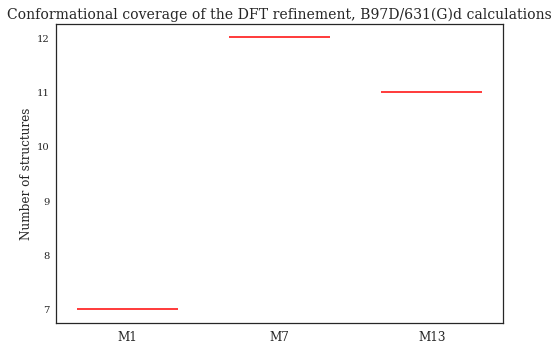

In [95]:
set_style()
fig, ax = plt.subplots()

ax.set_title("Conformational coverage of the DFT refinement, B97D/631(G)d calculations", fontsize=14)
ax.set_ylabel("Number of structures", fontsize=12)
ax.set_xticks([1.0, 2.5, 4.0])
ax.set_xticklabels(["M1", "M7", "M13"], fontsize=12)



ax.hlines(len(inps_m1), 0.5, 1.5, linestyle='-', color='r', linewidth=1.5)
ax.hlines(len(inps_m7), 2.0, 3.0, linestyle='-', color='r', linewidth=1.5)
ax.hlines(len(inps_m13), 3.5, 4.5, linestyle='-', color='r', linewidth=1.5)


#ax.text(0, 0,
#"E1 = Sum of electronic and zero-point Energies\n\
#E2 = Sum of electronic and thermal Energies\n\
#E3 = Sum of electronic and thermal Enthalpies\n\
#E4 = Sum of electronic and thermal Free Energies")

The geometrical-similarity network. The nodes denote the structures and the numbering corresponds to the energy values in ascending order ('1' refers to the global minimum).


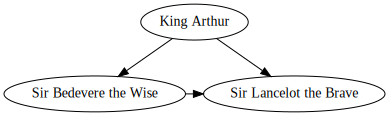

In [90]:
print(
"The geometrical-similarity network.\
 The nodes denote the structures and the numbering corresponds to the energy values in ascending order\
 ('1' refers to the global minimum).")

from graphviz import Digraph

dot = Digraph(comment='The Round Table')

dot.node('A', 'King Arthur')
dot.node('B', 'Sir Bedevere the Wise')
dot.node('L', 'Sir Lancelot the Brave')

dot.edges(['AB', 'AL'])
dot.edge('B', 'L', constraint='false')

dot




### Thermodynamic properties

In [82]:
m1_results = "/home/gosia/work/work_on_gitlab/icho/calcs/m1/gaussian_results/FINAL_RESULTS_selected_conformers_thermochemistry_b97d_631gd.csv"
m1_data    = pd.read_csv(m1_results, 
                         skiprows=18, 
                         usecols=[0,5,6,7,8,9,10],
                         delimiter=r"\s+")
m1_data

,#Mol,E1-E1(min)[kcal/mol],E2-E2(min)[kcal/mol],E3-E3(min)[kcal/mol],E4-E4(min)[kcal/mol],Boltzmann_weight,Mol_fraction
0,m1_b_sdf_3,0.000000,0.000000,0.000000,0.000000,1.000000,0.142874
1,m1_b_sdf_0,1.362950,1.451429,1.451429,2.447287,0.999984,0.142872
2,m1_rdkit_smi_10,15.151842,14.835577,14.835577,18.207185,0.999879,0.142857
3,m1_rdkit_smi_51,21.314611,21.310846,21.310846,23.058460,0.999846,0.142853
4,m1_rdkit_smi_16,22.411498,22.298546,22.298546,24.544402,0.999837,0.142851
5,m1_rdkit_smi_32,26.800926,27.136016,27.136016,28.170779,0.999812,0.142848
6,m1_rdkit_sdf_26,29.319749,29.443368,29.443368,31.214827,0.999792,0.142845


In [83]:
m7_results = "/home/gosia/work/work_on_gitlab/icho/calcs/m7/gaussian_results/FINAL_RESULTS_selected_conformers_thermochemistry_b97d_631gd.csv"
m7_data    = pd.read_csv(m7_results, 
                         skiprows=18, 
                         usecols=[0,5,6,7,8,9,10],
                         delimiter=r"\s+")
m7_data

,#Mol,E1-E1(min)[kcal/mol],E2-E2(min)[kcal/mol],E3-E3(min)[kcal/mol],E4-E4(min)[kcal/mol],Boltzmann_weight,Mol_fraction
0,m7_b_sdf_20,0.000000,0.000000,0.000000,0.000000,1.000000,0.083343
1,m7_b_sdf_6,0.061496,0.123619,0.123619,-1.327182,1.000009,0.083343
2,m7_b_smi_0,0.815135,0.806350,0.806350,0.651982,0.999996,0.083342
3,m7_b_sdf_0,0.837725,0.846510,0.846510,0.534010,0.999996,0.083342
4,m7_rdkit_sdf_70,19.072520,19.202415,19.202415,18.099253,0.999879,0.083333
5,m7_rdkit_smi_24,20.544030,20.663257,20.663257,19.185472,0.999872,0.083332
6,m7_rdkit_smi_81,25.288628,25.392795,25.392795,24.044905,0.999840,0.083329
7,m7_rdkit_smi_94,26.262523,26.498467,26.498467,23.748720,0.999842,0.083329
8,m7_rdkit_smi_15,29.063097,29.415758,29.415758,27.086443,0.999820,0.083328
9,m7_rdkit_sdf_104,31.406845,31.612668,31.612668,30.395927,0.999798,0.083326


In [84]:
m13_results = "/home/gosia/work/work_on_gitlab/icho/calcs/m13/gaussian_results/FINAL_RESULTS_selected_conformers_thermochemistry_b97d_631gd.csv"
m13_data    = pd.read_csv(m13_results, 
                         skiprows=18, 
                         usecols=[0,5,6,7,8,9,10],
                         delimiter=r"\s+")
m13_data

,#Mol,E1-E1(min)[kcal/mol],E2-E2(min)[kcal/mol],E3-E3(min)[kcal/mol],E4-E4(min)[kcal/mol],Boltzmann_weight,Mol_fraction
0,m13_b_sdf_2,0.000000,0.000000,0.000000,0.000000,1.000000,0.100005
1,m13_rdkit_smi_193,0.747364,0.230923,0.230923,2.232051,0.999985,0.100004
2,m13_rdkit_smi_122,5.729788,5.601776,5.601776,5.764301,0.999962,0.100001
3,m13_rdkit_sdf_103,6.267564,6.047308,6.047308,7.277854,0.999952,0.100000
4,m13_b_sdf_116,7.430339,7.809354,7.809354,5.309357,0.999965,0.100001
5,m13_rdkit_smi_59,7.667537,7.725268,7.725896,6.076801,0.999960,0.100001
6,m13_rdkit_smi_133,7.961839,7.845122,7.845750,7.512542,0.999950,0.100000
7,m13_rdkit_smi_148,12.252121,12.594113,12.594741,10.110431,0.999933,0.099998
8,m13_rdkit_smi_180,12.812487,12.898456,12.899083,10.972002,0.999927,0.099998
9,m13_rdkit_sdf_43,22.004872,22.095233,22.095233,20.266671,0.999865,0.099992


In [48]:
# functions used for plots
def plot_line(ax, data, xmin, xmax):
    for i, v in enumerate(data):
        # data is sorted; the first element corresponds to the lowest energy; we'll plot it in red
        if i == 0:
            ax.hlines(v, xmin, xmax, linestyle='-', color='r', linewidth=1.5)
        else:
            ax.hlines(v, xmin, xmax, linestyle='-', linewidth=1)

def set_style():
    sns.set_context("paper")
    sns.set(font='serif')
    sns.set_style("white", {
        "font.family": "serif",
        "font.serif": ["Times", "Palatino", "serif"]
    })

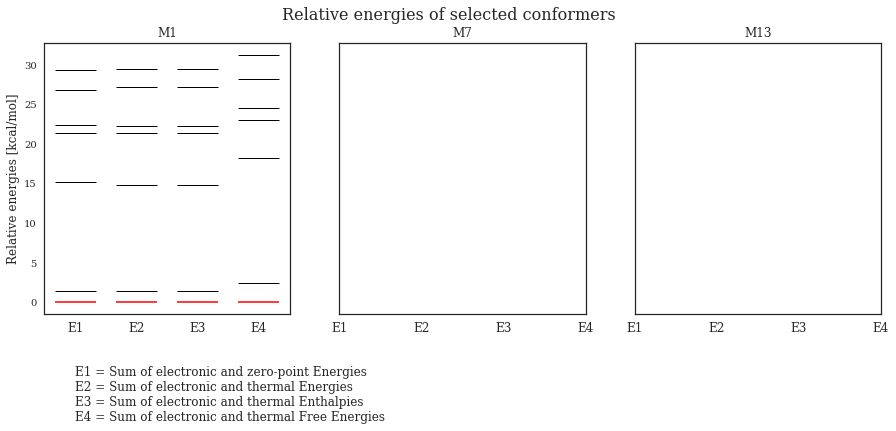

In [49]:
# plot - all macrocycles side by side
set_style()
fig, (ax1, ax7, ax13) = plt.subplots(1,3,sharey=True,figsize=(15,5))

fig.suptitle("Relative energies of selected conformers", fontsize=16)
ax1.set_title("M1")
ax7.set_title("M7")
ax13.set_title("M13")

ax1.set_ylabel("Relative energies [kcal/mol]", fontsize=12)

for ax in [ax1, ax7, ax13]:
    ax.set_xticks([0.0, 1.5, 3.0, 4.5])
    ax.set_xticklabels(["E1", "E2", "E3", "E4"], fontsize=12)


# plot
# m1
plot_line(ax1, m1_data["E1-E1(min)[kcal/mol]"], -0.5, 0.5)
plot_line(ax1, m1_data["E2-E2(min)[kcal/mol]"],  1.0, 2.0)
plot_line(ax1, m1_data["E3-E3(min)[kcal/mol]"],  2.5, 3.5)
plot_line(ax1, m1_data["E4-E4(min)[kcal/mol]"],  4.0, 5.0)

# m7

# m13


ax1.text(0, -15,
"E1 = Sum of electronic and zero-point Energies\n\
E2 = Sum of electronic and thermal Energies\n\
E3 = Sum of electronic and thermal Enthalpies\n\
E4 = Sum of electronic and thermal Free Energies")

## M1

### Energy landscapes

In [3]:
f_m1 = "/home/gosia/work/work_on_gitlab/icho/calcs/m1/gaussian_results/FINAL_RESULTS_selected_conformers_thermochemistry_b97d_631gd.csv"
m1_data = pd.read_csv(f_m1, 
                      skiprows=18, 
                      usecols=[0,5,6,7,8,9,10],
                      delimiter=r"\s+")

f_m1_h2o = "/home/gosia/work/work_on_gitlab/icho/calcs/m1-h2o/gaussian_results/FINAL_RESULTS_selected_conformers_thermochemistry_b97d_631gd.csv"
m1_h2o_data = pd.read_csv(f_m1_h2o, 
                      skiprows=18, 
                      usecols=[0,5,6,7,8,9,10],
                      delimiter=r"\s+")

f_m1_2h2o = "/home/gosia/work/work_on_gitlab/icho/calcs/m1-2h2o/gaussian_results/FINAL_RESULTS_selected_conformers_thermochemistry_b97d_631gd.csv"
m1_2h2o_data = pd.read_csv(f_m1_2h2o, 
                      skiprows=18, 
                      usecols=[0,5,6,7,8,9,10],
                      delimiter=r"\s+")

f_m1_h2o_dmso = "/home/gosia/work/work_on_gitlab/icho/calcs/m1-h2o-dmso/gaussian_results/FINAL_RESULTS_selected_conformers_thermochemistry_b97d_631gd.csv"
m1_h2o_dmso_data = pd.read_csv(f_m1_h2o_dmso, 
                      skiprows=18, 
                      usecols=[0,5,6,7,8,9,10],
                      delimiter=r"\s+")

f_m1_2h2o_dmso = "/home/gosia/work/work_on_gitlab/icho/calcs/m1-2h2o-dmso/gaussian_results/FINAL_RESULTS_selected_conformers_thermochemistry_b97d_631gd.csv"
m1_2h2o_dmso_data = pd.read_csv(f_m1_2h2o_dmso, 
                      skiprows=18, 
                      usecols=[0,5,6,7,8,9,10],
                      delimiter=r"\s+")

f_m1_h2o_methanol = "/home/gosia/work/work_on_gitlab/icho/calcs/m1-h2o-methanol/gaussian_results/FINAL_RESULTS_selected_conformers_thermochemistry_b97d_631gd.csv"
m1_h2o_methanol_data = pd.read_csv(f_m1_h2o_methanol, 
                      skiprows=18, 
                      usecols=[0,5,6,7,8,9,10],
                      delimiter=r"\s+")

f_m1_2h2o_methanol = "/home/gosia/work/work_on_gitlab/icho/calcs/m1-2h2o-methanol/gaussian_results/FINAL_RESULTS_selected_conformers_thermochemistry_b97d_631gd.csv"
m1_2h2o_methanol_data = pd.read_csv(f_m1_2h2o_methanol, 
                      skiprows=18, 
                      usecols=[0,5,6,7,8,9,10],
                      delimiter=r"\s+")

### Geometries of conformers

## M7

### Energy landscapes

### Geometries of conformers

## M13

### Energy landscapes

### Geometries of conformers

## Comparison of all systems under study

| Mol | No. of conformers (start) | No. of conformers (end) | RMSD range | E range | 
|-----|---------------------------|-------------------------|
| M1 | | | 
| M1 + H2O |  | | 
| M1 + 2H2O | | | 
| M1 + H2O + methanol |  | | 
| M1 + 2H2O + methanol | | | 
| M1 + H2O + DMSO |  | | 
| M1 + 2H2O + DMSO | | | 
|     | | | 
| M7  |  | | 
| M7 + H2O |  | | 
| M7 + 2H2O | | | 
| M7 + H2O + methanol |  | | 
| M7 + 2H2O + methanol | | | 
| M7 + H2O + DMSO |  | | 
| M7 + 2H2O + DMSO | | | 
|     | | | 
| M13 | | | 
| M13 + H2O |  | | 
| M13 + 2H2O | | | 
| M13 + H2O + methanol |  | | 
| M13 + 2H2O + methanol | | | 
| M13 + H2O + DMSO |  | | 
| M13 + 2H2O + DMSO | | | 
|     | | | 


* *Mol* is a molecular system under study; for systems in solution: M + nH2O (n = 1, 2) were treated explicitly, while methanol and DMSO were treated implicitly as a continuum medium characterized by its dielectric constant


* *No. of conformers (start)* is the number of conformers which were generated and selected (after pre-screening) from the conformer generation and molecular mechanics optimisation step


* *No. of conformers (end)* is the number of conformers which were selected as distinct (in terms of root-mean-square-distance between heavy atoms in conformer pairs and in terms of energy) after DFT geometry optimisation


* *RMSD range* - the minimum and maximum values of RMSD; RMSD is a root-mean-square-distance between heavy atoms in conformers, it is a measure of how much distinct the conformers are


* *Energy range* - the minimum and maximum values of Energy [a.u.]



## Possible questions:

* how does the presence of nH2O (n = 1, 2) affect the geometries and energies of macrocycles?

* how does the presence of solution (methanol, DMSO) influence the geometries and energetics of M + nH2O complexes? How much the geometries and energetics of M + nH2O complexes depend on the solvent used?

* how reliable is this analysis? evaluation of the 


## Next steps (?):